<a href="https://www.kaggle.com/code/kenny3s/iht-pyiqa-sadcnn?scriptVersionId=152973687" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import tarfile
 
# 定义要解压的 .tgz 文件路径
filename = "/kaggle/input/lfwpeople/lfw-funneled.tgz"
 
# 创建 TarFile 对象并打开 .tgz 文件
with tarfile.open(filename) as tf:
    # 将所有文件提取到当前目录（或指定其他目标目录）
    tf.extractall()
    
print("解压完成！")

解压完成！


In [2]:
import os
data_dir = "/kaggle/working/lfw_funneled"
half_dir = "/kaggle/input/encryption-3"
re_dir = "/kaggle/input/re-encryption-3"

iht_dir = '/kaggle/input/lfw-iht'
p = []
for person in os.listdir(iht_dir):
    p.append(person)
p

['Colin_Powell',
 'Jean_Chretien',
 'Hugo_Chavez',
 'Gerhard_Schroeder',
 'John_Ashcroft',
 'Donald_Rumsfeld',
 'Ariel_Sharon',
 'Jacques_Chirac',
 'George_W_Bush',
 'Serena_Williams',
 'Tony_Blair',
 'Junichiro_Koizumi']

In [3]:
!pip install pyiqa
#https://www.kaggle.com/discussions/questions-and-answers/426884
!sed -i 's/from scipy.spatial import ConvexHull, QhullError/from scipy.spatial import ConvexHull/g' /opt/conda/lib/python3.10/site-packages/skimage/morphology/convex_hull.py

  Obtaining dependency information for pyiqa from https://files.pythonhosted.org/packages/c6/ae/bff1d01ccb94051b8c06c152680336aa142174f80917968015e8b6dcc2d7/pyiqa-0.1.8-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 12.7 MB/s eta 0:00:00
  Obtaining dependency information for tb-nightly from https://files.pythonhosted.org/packages/be/1c/4fc18421d545a36de92eecae2a347e3fe7393f02b151750fc9182b758e32/tb_nightly-2.16.0a20231129-py3-none-any.whl.metadata
  Obtaining dependency information for einops from https://files.pythonhosted.org/packages/29/0b/2d1c0ebfd092e25935b86509a9a817159212d82aa43d7fb07eca4eeff2c2/einops-0.7.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 58.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for ftfy from https://files.pythonhosted.org/packages/91/f8/dfa32d06cfcbdb76bc46e0f5d69c537de33f4cedb1a15cd4746ab45a6a26/ftfy-6.1.3-py3-none-any.whl.metadata

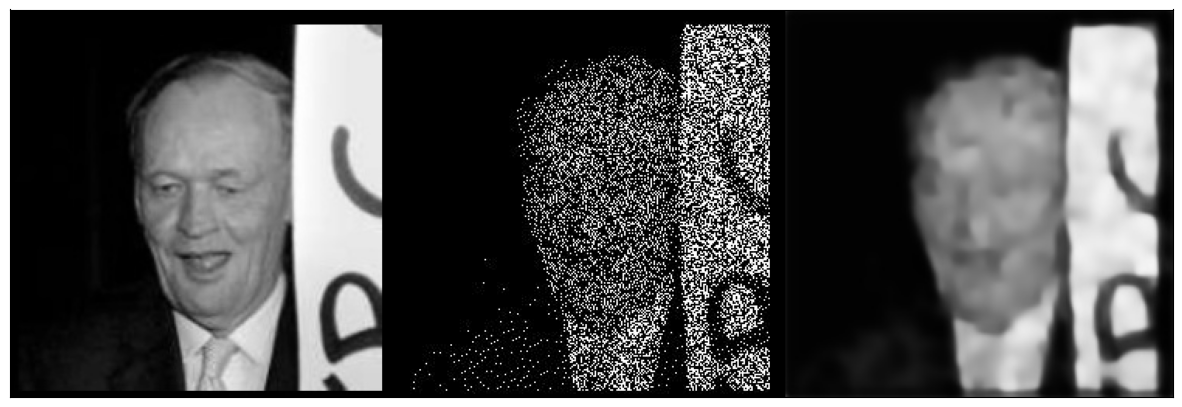

In [4]:
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
for person in p[1:2]:
    for img in os.listdir(os.path.join(data_dir, person))[1:2]:
        color = Image.open(f"{data_dir}/{person}/{img}")
        iht = Image.open(f"{half_dir}/{person}/{img}")  # Assuming this returns a NumPy array
        sa = Image.open(f"{re_dir}/{person}/{img}")
        
        color = color.convert('L').convert("RGB")
        iht = iht.convert("RGB")
        sa = sa.convert("RGB")
        
        # Convert the images to NumPy arrays and stack them horizontally
        rst = np.hstack([np.array(color), np.array(iht), np.array(sa)])

        # Convert the result back to a PIL image
        rst = Image.fromarray(rst)

        plt.figure(figsize=(15, 15))  
        plt.xticks([]) 
        plt.yticks([]) 
        plt.imshow(rst)
        plt.show()


In [5]:
import os
import torch
from PIL import Image
import pyiqa

from tqdm import tqdm
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

psnr_metric = pyiqa.create_metric('psnr', device=device)
ssim_metric = pyiqa.create_metric('ssim', device=device)
clip_metric = pyiqa.create_metric('clipiqa+', device=device)
ms_ssim_metric = pyiqa.create_metric('ms_ssim', device=device)
lpips_metric = pyiqa.create_metric('lpips', device=device)
dists_metric = pyiqa.create_metric('dists', device=device)
fid_metric = pyiqa.create_metric('fid', device=device)

def calculate_quality(x, y, z):
    quality = {
        'psnr1': psnr_metric(x, y).item(),
        'psnr2': psnr_metric(x, z).item(),
        'ssim1': ssim_metric(x, y).item(),
        'ssim2': ssim_metric(x, z).item(),
        "ms_ssim1": ms_ssim_metric(x, y).item(),
        "ms_ssim2": ms_ssim_metric(x, z).item(),
        "clip_iqa1": clip_metric(y).item(),
        "clip_iqa2": clip_metric(z).item(),
        "lpips1": lpips_metric(x, y).item(),
        "lpips2": lpips_metric(x, z).item(),
        "dists1": dists_metric(x, y).item(),
        "dists2": dists_metric(x, z).item(),
    }

    return quality

def calculate_fid(x, y, z):
    quality = {
        'fid1': fid_metric(x, y).item(),
        'fid2': fid_metric(x, z).item(),
    }
    return quality

# Initialize a dictionary to store the average quality for each class
average_quality = {}

for person in p:
    quality_sum = {}
    fid_sum = {}
    
    quality_fid = calculate_fid(f"{data_dir}/{person}",f"{half_dir}/{person}",f"{re_dir}/{person}" )
    for key, value in quality_fid.items():
        fid_sum[key] = quality_sum.get(key, 0) + value
        
    for img in os.listdir(os.path.join(data_dir, person)):
        color = Image.open(f"{data_dir}/{person}/{img}")
        iht = Image.open(f"{half_dir}/{person}/{img}") 
        sa = Image.open(f"{re_dir}/{person}/{img}")
        
        color = color.convert('L').convert("RGB")
        iht = iht.convert("RGB")
        sa = sa.convert("RGB")

        # Calculate the quality for this image
        quality = calculate_quality(color, iht, sa)

        # Update the sum of the quality
        for key, value in quality.items():
            quality_sum[key] = quality_sum.get(key, 0) + value
    
    
    # Calculate the average quality for this class
    num_images = len(os.listdir(os.path.join(data_dir, person)))
    average_quality[person] = {key: value / num_images for key, value in quality_sum.items()}
    average_quality[person].update({key: value for key, value in fid_sum.items()})


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-11-30 05:48:54,309 INFO: Metric [PSNR] is created.
2023-11-30 05:48:54,311 INFO: Metric [SSIM] is created.
100%|███████████████████████████████████████| 244M/244M [00:03<00:00, 83.1MiB/s]


Downloading: "https://github.com/chaofengc/IQA-PyTorch/releases/download/v0.1-weights/CLIP-IQA+_learned_prompts-603f3273.pth" to /root/.cache/torch/hub/checkpoints/CLIP-IQA+_learned_prompts-603f3273.pth



100%|██████████| 16.7k/16.7k [00:00<00:00, 6.21MB/s]
2023-11-30 05:49:04,230 INFO: Metric [CLIPIQA] is created.
2023-11-30 05:49:04,231 INFO: Metric [MS_SSIM] is created.
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:00<00:00, 261MB/s]  


Downloading: "https://github.com/chaofengc/IQA-Toolbox-Python/releases/download/v0.1-weights/LPIPS_v0.1_alex-df73285e.pth" to /root/.cache/torch/hub/checkpoints/LPIPS_v0.1_alex-df73285e.pth



100%|██████████| 5.87k/5.87k [00:00<00:00, 3.07MB/s]
2023-11-30 05:49:06,560 INFO: Metric [LPIPS] is created.


Loading pretrained model LPIPS from /root/.cache/torch/hub/checkpoints/LPIPS_v0.1_alex-df73285e.pth


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 313MB/s]  


Downloading: "https://github.com/chaofengc/IQA-PyTorch/releases/download/v0.1-weights/DISTS_weights-f5e65c96.pth" to /root/.cache/torch/hub/checkpoints/DISTS_weights-f5e65c96.pth



100%|██████████| 12.0k/12.0k [00:00<00:00, 6.36MB/s]
2023-11-30 05:49:10,410 INFO: Metric [DISTS] is created.
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loading pretrained model DISTS from /root/.cache/torch/hub/checkpoints/DISTS_weights-f5e65c96.pth
Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth



100%|██████████| 91.2M/91.2M [00:00<00:00, 195MB/s] 
2023-11-30 05:49:11,769 INFO: Metric [FID] is created.


Loading pretrained model Inception3 from /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
compute FID between two folders


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Found 236 images in the folder /kaggle/working/lfw_funneled/Colin_Powell


FID Colin_Powell: 100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Found 236 images in the folder /kaggle/input/encryption-3/Colin_Powell


FID Colin_Powell: 100%|██████████| 8/8 [00:02<00:00,  3.73it/s]


compute FID between two folders
Found 236 images in the folder /kaggle/working/lfw_funneled/Colin_Powell


FID Colin_Powell: 100%|██████████| 8/8 [00:01<00:00,  4.38it/s]


Found 236 images in the folder /kaggle/input/re-encryption-3/Colin_Powell


FID Colin_Powell: 100%|██████████| 8/8 [00:01<00:00,  4.28it/s]


compute FID between two folders
Found 55 images in the folder /kaggle/working/lfw_funneled/Jean_Chretien


FID Jean_Chretien: 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


Found 55 images in the folder /kaggle/input/encryption-3/Jean_Chretien


FID Jean_Chretien: 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


compute FID between two folders
Found 55 images in the folder /kaggle/working/lfw_funneled/Jean_Chretien


FID Jean_Chretien: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


Found 55 images in the folder /kaggle/input/re-encryption-3/Jean_Chretien


FID Jean_Chretien: 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


compute FID between two folders
Found 71 images in the folder /kaggle/working/lfw_funneled/Hugo_Chavez


FID Hugo_Chavez: 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]


Found 71 images in the folder /kaggle/input/encryption-3/Hugo_Chavez


FID Hugo_Chavez: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


compute FID between two folders
Found 71 images in the folder /kaggle/working/lfw_funneled/Hugo_Chavez


FID Hugo_Chavez: 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


Found 71 images in the folder /kaggle/input/re-encryption-3/Hugo_Chavez


FID Hugo_Chavez: 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


compute FID between two folders
Found 109 images in the folder /kaggle/working/lfw_funneled/Gerhard_Schroeder


FID Gerhard_Schroeder: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Found 109 images in the folder /kaggle/input/encryption-3/Gerhard_Schroeder


FID Gerhard_Schroeder: 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


compute FID between two folders
Found 109 images in the folder /kaggle/working/lfw_funneled/Gerhard_Schroeder


FID Gerhard_Schroeder: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


Found 109 images in the folder /kaggle/input/re-encryption-3/Gerhard_Schroeder


FID Gerhard_Schroeder: 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


compute FID between two folders
Found 53 images in the folder /kaggle/working/lfw_funneled/John_Ashcroft


FID John_Ashcroft: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


Found 53 images in the folder /kaggle/input/encryption-3/John_Ashcroft


FID John_Ashcroft: 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


compute FID between two folders
Found 53 images in the folder /kaggle/working/lfw_funneled/John_Ashcroft


FID John_Ashcroft: 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


Found 53 images in the folder /kaggle/input/re-encryption-3/John_Ashcroft


FID John_Ashcroft: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


compute FID between two folders
Found 121 images in the folder /kaggle/working/lfw_funneled/Donald_Rumsfeld


FID Donald_Rumsfeld: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s]


Found 121 images in the folder /kaggle/input/encryption-3/Donald_Rumsfeld


FID Donald_Rumsfeld: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]


compute FID between two folders
Found 121 images in the folder /kaggle/working/lfw_funneled/Donald_Rumsfeld


FID Donald_Rumsfeld: 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]


Found 121 images in the folder /kaggle/input/re-encryption-3/Donald_Rumsfeld


FID Donald_Rumsfeld: 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]


compute FID between two folders
Found 77 images in the folder /kaggle/working/lfw_funneled/Ariel_Sharon


FID Ariel_Sharon: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Found 77 images in the folder /kaggle/input/encryption-3/Ariel_Sharon


FID Ariel_Sharon: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


compute FID between two folders
Found 77 images in the folder /kaggle/working/lfw_funneled/Ariel_Sharon


FID Ariel_Sharon: 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]


Found 77 images in the folder /kaggle/input/re-encryption-3/Ariel_Sharon


FID Ariel_Sharon: 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]


compute FID between two folders
Found 52 images in the folder /kaggle/working/lfw_funneled/Jacques_Chirac


FID Jacques_Chirac: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


Found 52 images in the folder /kaggle/input/encryption-3/Jacques_Chirac


FID Jacques_Chirac: 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


compute FID between two folders
Found 52 images in the folder /kaggle/working/lfw_funneled/Jacques_Chirac


FID Jacques_Chirac: 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


Found 52 images in the folder /kaggle/input/re-encryption-3/Jacques_Chirac


FID Jacques_Chirac: 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


compute FID between two folders
Found 530 images in the folder /kaggle/working/lfw_funneled/George_W_Bush


FID George_W_Bush: 100%|██████████| 17/17 [00:03<00:00,  5.33it/s]


Found 530 images in the folder /kaggle/input/encryption-3/George_W_Bush


FID George_W_Bush: 100%|██████████| 17/17 [00:03<00:00,  4.96it/s]


compute FID between two folders
Found 530 images in the folder /kaggle/working/lfw_funneled/George_W_Bush


FID George_W_Bush: 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]


Found 530 images in the folder /kaggle/input/re-encryption-3/George_W_Bush


FID George_W_Bush: 100%|██████████| 17/17 [00:03<00:00,  5.47it/s]


compute FID between two folders
Found 52 images in the folder /kaggle/working/lfw_funneled/Serena_Williams


FID Serena_Williams: 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


Found 52 images in the folder /kaggle/input/encryption-3/Serena_Williams


FID Serena_Williams: 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


compute FID between two folders
Found 52 images in the folder /kaggle/working/lfw_funneled/Serena_Williams


FID Serena_Williams: 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


Found 52 images in the folder /kaggle/input/re-encryption-3/Serena_Williams


FID Serena_Williams: 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


compute FID between two folders
Found 144 images in the folder /kaggle/working/lfw_funneled/Tony_Blair


FID Tony_Blair: 100%|██████████| 5/5 [00:01<00:00,  3.69it/s]


Found 144 images in the folder /kaggle/input/encryption-3/Tony_Blair


FID Tony_Blair: 100%|██████████| 5/5 [00:01<00:00,  3.50it/s]


compute FID between two folders
Found 144 images in the folder /kaggle/working/lfw_funneled/Tony_Blair


FID Tony_Blair: 100%|██████████| 5/5 [00:01<00:00,  3.73it/s]


Found 144 images in the folder /kaggle/input/re-encryption-3/Tony_Blair


FID Tony_Blair: 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]


compute FID between two folders
Found 60 images in the folder /kaggle/working/lfw_funneled/Junichiro_Koizumi


FID Junichiro_Koizumi: 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


Found 60 images in the folder /kaggle/input/encryption-3/Junichiro_Koizumi


FID Junichiro_Koizumi: 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


compute FID between two folders
Found 60 images in the folder /kaggle/working/lfw_funneled/Junichiro_Koizumi


FID Junichiro_Koizumi: 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


Found 60 images in the folder /kaggle/input/re-encryption-3/Junichiro_Koizumi


FID Junichiro_Koizumi: 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


## 后缀为1代表P3解密图像
## 后缀为2代表SADCNN逆半调

In [6]:
import pandas as pd

# Convert the dictionary to a DataFrame
df = pd.DataFrame(average_quality)

# Transpose the DataFrame so that each row corresponds to a person
df = df.transpose()

# Display the DataFrame
print(df)

# Save the DataFrame as a CSV file
df.to_csv('quality_metrics.csv')

                      psnr1      psnr2     ssim1     ssim2  ms_ssim1  \
Colin_Powell       7.655356  23.395437  0.098942  0.713451  0.409507   
Jean_Chretien      8.045172  23.644029  0.120662  0.716261  0.426976   
Hugo_Chavez        7.473371  23.018155  0.075300  0.711227  0.408236   
Gerhard_Schroeder  7.403064  23.345281  0.079925  0.720294  0.396359   
John_Ashcroft      7.546360  23.794351  0.059986  0.733461  0.388329   
Donald_Rumsfeld    7.832813  22.998538  0.099597  0.697004  0.417850   
Ariel_Sharon       7.482220  23.525537  0.077086  0.727712  0.391339   
Jacques_Chirac     7.244925  23.511762  0.093129  0.718321  0.387159   
George_W_Bush      7.601792  23.471014  0.080803  0.717140  0.404895   
Serena_Williams    7.594035  23.434581  0.061028  0.723691  0.400176   
Tony_Blair         7.574111  23.593829  0.070697  0.724172  0.392487   
Junichiro_Koizumi  7.117315  23.835195  0.043388  0.723501  0.367611   

                   ms_ssim2  clip_iqa1  clip_iqa2    lpips1    

## 基于LFW数据集中大于50图像的人脸
- 实线表示P3解密图像质量
- 虚线表示结构感知网络逆半色调图像质量
- LPIPS、DISTS、FID 是 lower-best IQA指标
- 右侧刻度用于PSNR与FID指标

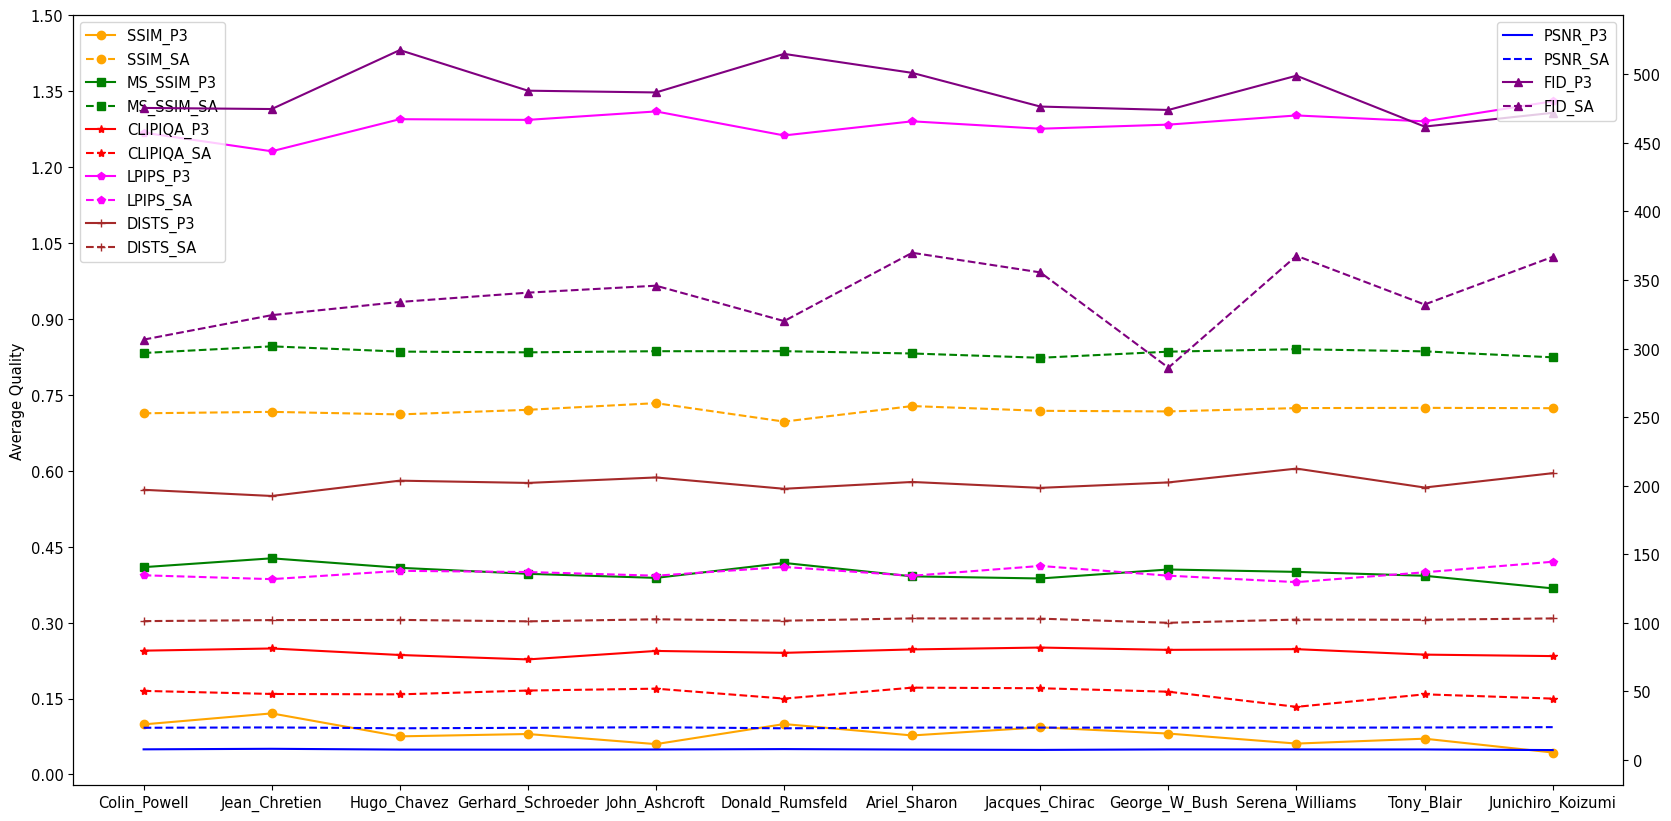

In [10]:
# Set the global font to be Times New Roman, 10.5pt size
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10.5

fig, ax1 = plt.subplots(figsize=(20, 10))

ax2 = ax1.twinx()
ax2.plot(list(average_quality.keys()), [quality['psnr1'] for quality in average_quality.values()], '-',  color='blue',label='PSNR_P3')
ax2.plot(list(average_quality.keys()), [quality['psnr2'] for quality in average_quality.values()], '--',  color='blue',label='PSNR_SA')

ax1.plot(list(average_quality.keys()), [quality['ssim1'] for quality in average_quality.values()], '-o', color='orange', label='SSIM_P3')
ax1.plot(list(average_quality.keys()), [quality['ssim2'] for quality in average_quality.values()], '--o', color='orange', label='SSIM_SA')

ax1.plot(list(average_quality.keys()), [quality['ms_ssim1'] for quality in average_quality.values()], '-s', color='green', label='MS_SSIM_P3')
ax1.plot(list(average_quality.keys()), [quality['ms_ssim2'] for quality in average_quality.values()], '--s', color='green', label='MS_SSIM_SA')

ax1.plot(list(average_quality.keys()), [quality['clip_iqa1'] for quality in average_quality.values()], '-*', color='red', label='CLIPIQA_P3')
ax1.plot(list(average_quality.keys()), [quality['clip_iqa2'] for quality in average_quality.values()], '--*', color='red', label='CLIPIQA_SA')

ax2.plot(list(average_quality.keys()), [quality['fid1'] for quality in average_quality.values()], '-^', color='purple', label='FID_P3')
ax2.plot(list(average_quality.keys()), [quality['fid2'] for quality in average_quality.values()], '--^', color='purple', label='FID_SA')

ax1.plot(list(average_quality.keys()), [quality['lpips1'] for quality in average_quality.values()], '-p', color='magenta', label='LPIPS_P3')
ax1.plot(list(average_quality.keys()), [quality['lpips2'] for quality in average_quality.values()], '--p', color='magenta', label='LPIPS_SA')

ax1.plot(list(average_quality.keys()), [quality['dists1'] for quality in average_quality.values()], '-+', color='brown', label='DISTS_P3')
ax1.plot(list(average_quality.keys()), [quality['dists2'] for quality in average_quality.values()], '--+', color='brown', label='DISTS_SA')

# Add labels to the y-axes
ax1.set_ylabel('Average Quality')

# Add a legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax1.set_yticks(np.arange(0, 1.65, 0.15))  # Set y-ticks for ax1
ax2.set_yticks(np.arange(0, 550, 50))  # Set y-ticks for ax2

plt.savefig('my_figure.png', dpi=300)
plt.show()